# Importing Packages

In [2]:
import numpy as np
import pandas as pd
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.quantization
import torchvision

import os

# Loading Model and Quantizing

In [34]:
from torchvision.models.quantization import (
    resnet18, resnet50, googlenet, inception_v3, mobilenet_v2, 
    mobilenet_v3_large, resnext101_32x8d, shufflenet_v2_x0_5
)
from torchvision.models.quantization import (
    GoogLeNet_QuantizedWeights, Inception_V3_QuantizedWeights, ResNet18_QuantizedWeights, 
    ResNet50_QuantizedWeights, MobileNet_V2_QuantizedWeights, 
    MobileNet_V3_Large_QuantizedWeights, ResNeXt101_32X8D_QuantizedWeights, 
    ShuffleNet_V2_X0_5_QuantizedWeights
)

# Dictionary to map model names to their corresponding weights classes
model_weights = {
    "googlenet": GoogLeNet_QuantizedWeights,
    "inception_v3": Inception_V3_QuantizedWeights,
    "resnet18": ResNet18_QuantizedWeights,
    "resnet50": ResNet50_QuantizedWeights,
    "mobilenet_v2": MobileNet_V2_QuantizedWeights,
    "mobilenet_v3_large": MobileNet_V3_Large_QuantizedWeights,
    "resnext101_32x8d": ResNeXt101_32X8D_QuantizedWeights,
    "shufflenet_v2_x0_5": ShuffleNet_V2_X0_5_QuantizedWeights
}

# Dictionary to map model names to their corresponding constructors
model_constructors = {
    "googlenet": googlenet,
    "inception_v3": inception_v3,
    "resnet18": resnet18,
    "resnet50": resnet50,
    "mobilenet_v2": mobilenet_v2,
    "mobilenet_v3_large": mobilenet_v3_large,
    "resnext101_32x8d": resnext101_32x8d,
    "shufflenet_v2_x0_5": shufflenet_v2_x0_5
}

# Load all models with their best available weights and preprocess functions
quant_models = []

for model_name in model_weights:
    weights = model_weights[model_name].DEFAULT
    try:
        model = model_constructors[model_name](weights=weights, quantize=True)
        print("Loaded model", model_name)
    except:
        print("Skipping model", model_name)
        continue
    model.eval()
    quant_models.append((model_name, model))

Skipping model googlenet


/home/adam-taback/miniconda3/envs/fbgemm/lib/python3.12/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Skipping model inception_v3
Skipping model resnet18
Skipping model resnet50


/home/adam-taback/miniconda3/envs/fbgemm/lib/python3.12/site-packages/torch/ao/quantization/utils.py:339: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


Loaded model mobilenet_v2
Loaded model mobilenet_v3_large
Skipping model resnext101_32x8d
Skipping model shufflenet_v2_x0_5


In [39]:
get_intermediate_outputs(quant_models[0][1],(torch.rand(1,3,224,224)))[3].dtype
#extract_weights_biases(quant_models[1])[0][1]

torch.quint8

# Functions to Get Activations

In [40]:
# Function to capture intermediate outputs and prepare for quantization
def get_intermediate_outputs(model, input_data):
    intermediate_outputs = []

    def hook_fn(module, input, output):
        intermediate_outputs.append(input)
        intermediate_outputs.append(output)

    hooks = []
    for layer in model.children():
        hook = layer.register_forward_hook(hook_fn)
        hooks.append(hook)

    # Forward pass
    with torch.no_grad():
        model(input_data)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    return intermediate_outputs


def get_layer_weights(model, layer_weights=None, parent_name=''):
    if layer_weights is None:
        layer_weights = {}

    for name, layer in model.named_children():
        full_name = f"{parent_name}.{name}" if parent_name else name
        if hasattr(layer, 'weight') and layer.weight is not None:
            layer_weights[f"{full_name}.weight"] = layer.weight.detach().cpu().clone()
        if hasattr(layer, 'bias') and layer.bias is not None:
            layer_weights[f"{full_name}.bias"] = layer.bias.detach().cpu().clone()
        
        # Recursively capture weights of submodules
        get_layer_weights(layer, layer_weights, full_name)

    return layer_weights


# Quantize and save all tensors
def save_tensor_as_list(tensor, filename):
    tensor_list = tensor.cpu().numpy().tolist()  # Convert tensor to list
    with open(filename, 'w') as f:
        json.dump(tensor_list, f)
        
# save tensors as numpy files
def save_tensor_as_npy(tensor, filename):
    tensor_list = tensor.cpu().numpy()  # Convert tensor to list
    np.save(filename, tensor_list)

In [41]:
class CompTensor:
    def __init__(self, tensor):
        self.tensor = tensor
        self.shape = tensor.shape
        self.flat = tensor.flatten()

    def update_tensor(self):
        # update tensor with new values from self.flatten
        self.tensor = self.flatten.reshape(self.shape)
        
    def update_flatten(self):
        # update flatten with new values from self.tensor
        self.flat = self.tensor.flatten()
        
    def to(self, type):
        self.tensor = self.tensor.to(type)
        self.update_flatten()
        
        return self

# Generate Traces

In [43]:
# for each model, quantize and save tensors
n_layers = [] # number of layers per model

for k, model in enumerate(quant_models):
    print(f"Quantizing model {model[0]}")
    # Define an input tensor with appropriate shape
    input_tensors = [torch.randn(1, 3, 224, 224) for i in range(9)]  # For a single image of size 224x224 with 3 channels (RGB)

    # Capture intermediate outputs
    intermediate_outputs = []
    for data in input_tensors:
        intermediate_outputs.append(get_intermediate_outputs(model[1], data))
        
    # group tensors by layer
    layerwise_tensors = {}
    for i in range(len(intermediate_outputs)):
        for j in range(1,len(intermediate_outputs[i])-1): # only consider intermediate tensors (skip input and output)
            if j not in layerwise_tensors:
                layerwise_tensors[j] = []
            if intermediate_outputs[i][j][0].is_quantized:
                layerwise_tensors[j].append(intermediate_outputs[i][j][0].int_repr())
            else:
                layerwise_tensors[j].append(intermediate_outputs[i][j][0])

    # convert lists to tensors
    for j in layerwise_tensors:
        layerwise_tensors[j] = torch.stack(layerwise_tensors[j])
        
    # # print tensors
    # for j in layerwise_tensors:
    #     print(j, layerwise_tensors[j].shape)
        
        
    # Get unique values for each layer
    unique_layerwise_tensors = {}
    for j in layerwise_tensors:
        unique_layerwise_tensors[j] = torch.unique(layerwise_tensors[j].flatten())

    # print("Unique values per layer:")
    # for key, value in unique_layerwise_tensors.items():
    #     print(f"Layer {key}:")
    #     print(value)
        
    # flatten layerwise tensors
    flatten_layerwise_tensors = []

    for key in layerwise_tensors:
        flatten_layerwise_tensors.append(CompTensor((layerwise_tensors[key]).flatten()))
        
    # save all tensors as numpy files
    d = "trace/" + model[0] + "/"
        
    print("Saving tensors to", d)
    
    os.makedirs(os.path.dirname(d), exist_ok=True)
    
    for i in range(1, len(flatten_layerwise_tensors) + 1):
        save_tensor_as_npy(flatten_layerwise_tensors[i - 1].to(torch.uint8).tensor, d + "input_" + str(i) + "_flat.npy")
        
    for i in range(1,len(layerwise_tensors) + 1):
        save_tensor_as_npy(layerwise_tensors[i].to(torch.uint8), d + "input_" + str(i) + ".npy")
        
    n_layers.append(len(layerwise_tensors))

Quantizing model mobilenet_v2
Saving tensors to trace/mobilenet_v2/
Quantizing model mobilenet_v3_large
Saving tensors to trace/mobilenet_v3_large/


# Generating Symbol Tables for Traces

In [45]:
# run atalanta_numpy.py on the saved numpy files to get the symbol tables
import subprocess
from tqdm import tqdm

e_size = 8  # Number of bits per element

for k, model in enumerate((quant_models)):
    print(f"Running Atalanta on model {model[0]}")

    for i in (range(1, n_layers[k] + 1)):
        print("\tRunning Atalanta on input_" + str(i) + "_flat.npy")
        #tqdm.write(f"\tRunning Atalanta on input_{i}_flat.npy")

        # Define file to get trace from
        trace = f"trace/{model[0]}/input_{i}_flat.npy"

        # Define command
        command = ["python3", "atalanta/atalanta_numpy.py", trace, str(e_size)]
        
        # Run the command
        result = subprocess.run(command, capture_output=True, text=True)


Running Atalanta on model mobilenet_v2
	Running Atalanta on input_1_flat.npy
	Running Atalanta on input_2_flat.npy
	Running Atalanta on input_3_flat.npy
	Running Atalanta on input_4_flat.npy
	Running Atalanta on input_5_flat.npy
	Running Atalanta on input_6_flat.npy
Running Atalanta on model mobilenet_v3_large
	Running Atalanta on input_1_flat.npy
	Running Atalanta on input_2_flat.npy
	Running Atalanta on input_3_flat.npy
	Running Atalanta on input_4_flat.npy
	Running Atalanta on input_5_flat.npy
	Running Atalanta on input_6_flat.npy
	Running Atalanta on input_7_flat.npy
	Running Atalanta on input_8_flat.npy


In [46]:
for i in range(1, 7):
    print(layerwise_tensors[i].flatten().shape)

torch.Size([1354752])
torch.Size([1354752])
torch.Size([423360])
torch.Size([423360])
torch.Size([8640])
torch.Size([8640])


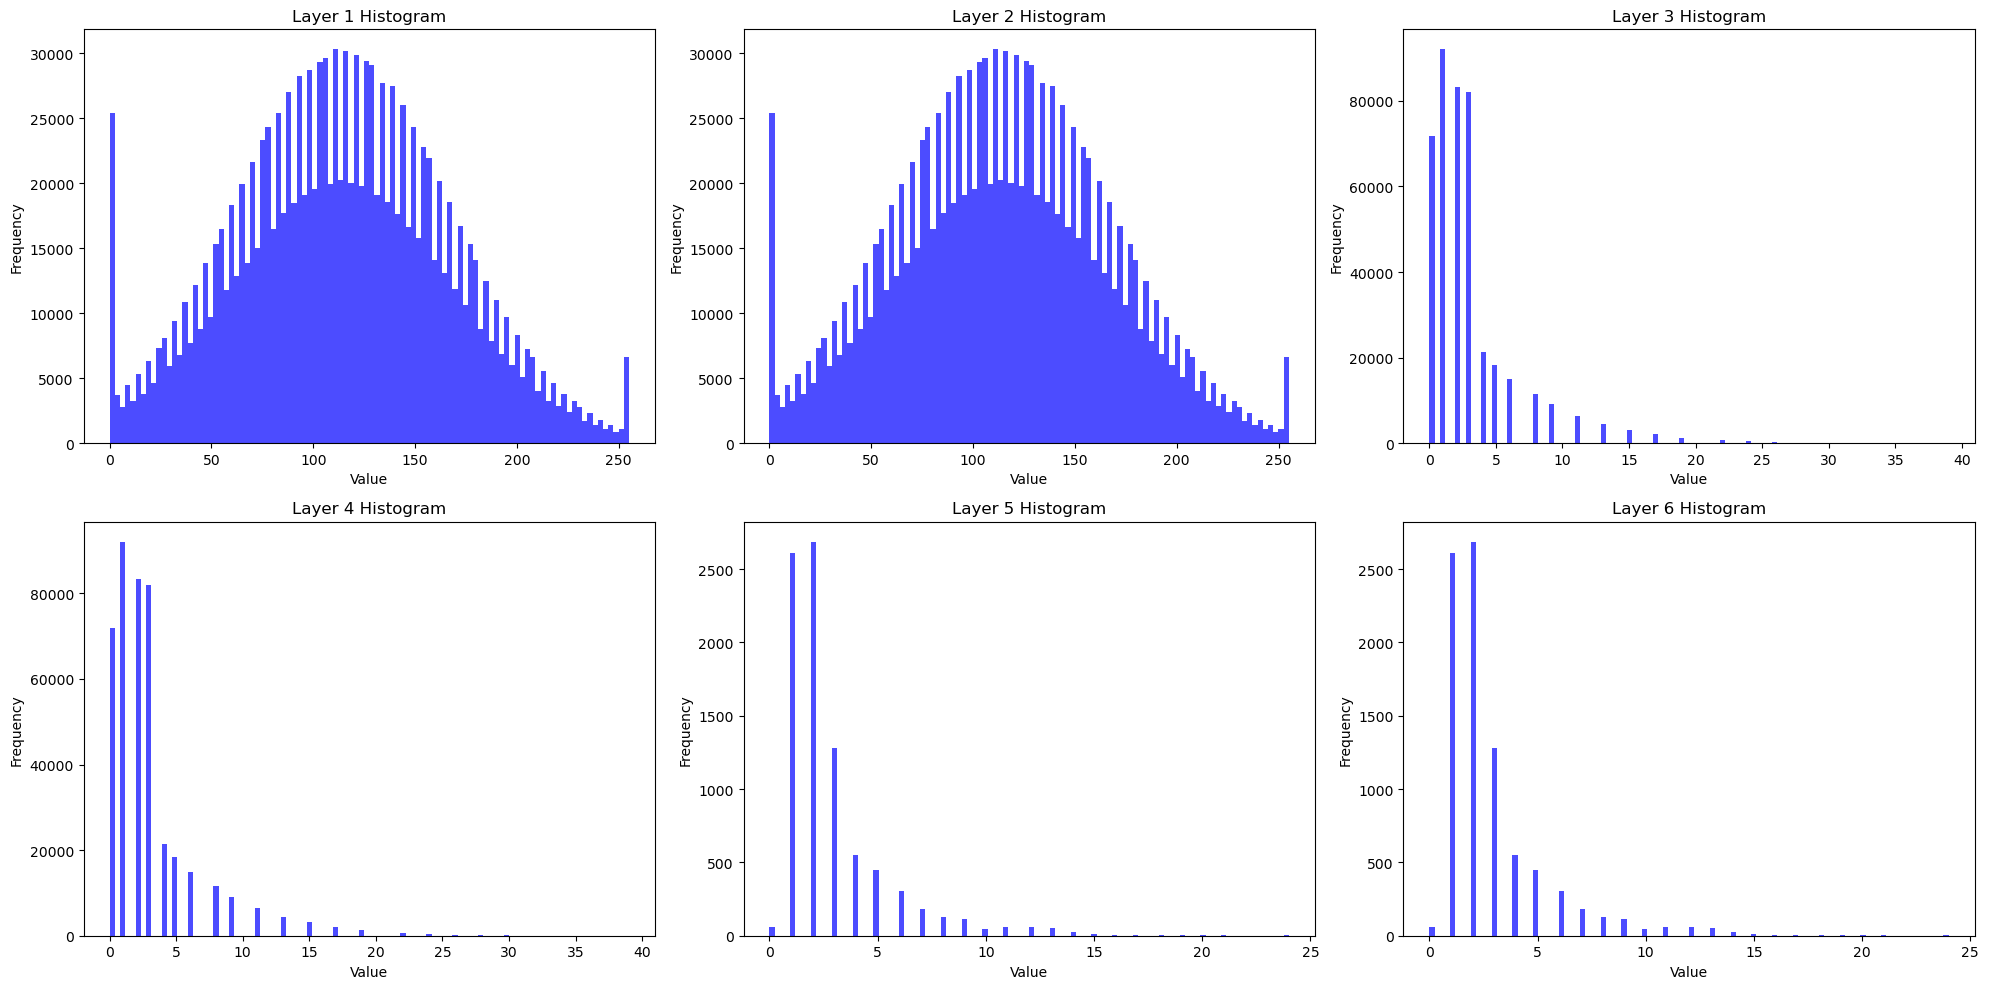

In [47]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 10))  # 2 rows and 4 columns

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histograms for each layer
for i in range(6):
    temp = flatten_layerwise_tensors[i]
    
    # Plot temp as histogram
    axes[i].hist(temp.flat.cpu().numpy(), bins=100, color='blue', alpha=0.7)
    axes[i].set_title(f"Layer {i+1} Histogram")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


# Generating Weights

In [50]:
# Function to extract weights and biases into numpy arrays, handling quantized tensors
def extract_weights_biases(model):
    weights_biases = []
    state_dict = model.state_dict()
    for name, param in state_dict.items():
        if isinstance(param, torch.Tensor):
            if 'weight' in name:
                if param.is_quantized:
                    # Dequantize the quantized tensor and change from qint8 to int8
                    param = param.int_repr()
                    # Convert int8 to uint8
                    param = param.to(torch.uint8)
                weights_biases.append(param.detach().cpu().numpy())
    return weights_biases

n_layers = []

for k, model in enumerate(quant_models):
    print(f"Extracting weights and biases for model {model[0]}")
    # Extract weights and biases into numpy arrays
    weights_biases = extract_weights_biases(model[1])

    # Save the extracted weights and biases
    d = "trace/" + model[0] + "/"
    os.makedirs(os.path.dirname(d), exist_ok=True)
    for i in range(len(weights_biases)):
        np.save(d + "weight_" + str(i) + ".npy", weights_biases[i])
        np.save(d + "weight_" + str(i) + "_flat.npy", weights_biases[i].flatten())
    n_layers.append(len(weights_biases))

Extracting weights and biases for model mobilenet_v2
Extracting weights and biases for model mobilenet_v3_large


# Generating Symbol Tables for Weights

In [51]:
# run atalanta_numpy.py on the saved numpy files to get the symbol tables
import subprocess
import os

e_size = 8 # number of bits per element

for k, model in enumerate(quant_models):
    print(f"Running Atalanta on model {model[0]}")

    for i in range(n_layers[k]):
        print("\tRunning Atalanta on weight_" + str(i) + ".npy")
        
        # define file to get trace from
        trace = "trace/" + model[0] + "/weight_" + str(i) + "_flat.npy"

        # define command
        command = ["python3", "atalanta/atalanta_numpy.py", trace, str(e_size)]
        
        # Run the command
        result = subprocess.run(command, capture_output=True, text=True)


Running Atalanta on model mobilenet_v2
	Running Atalanta on weight_0.npy
	Running Atalanta on weight_1.npy
	Running Atalanta on weight_2.npy
	Running Atalanta on weight_3.npy
	Running Atalanta on weight_4.npy
	Running Atalanta on weight_5.npy
	Running Atalanta on weight_6.npy
	Running Atalanta on weight_7.npy
	Running Atalanta on weight_8.npy
	Running Atalanta on weight_9.npy
	Running Atalanta on weight_10.npy
	Running Atalanta on weight_11.npy
	Running Atalanta on weight_12.npy
	Running Atalanta on weight_13.npy
	Running Atalanta on weight_14.npy
	Running Atalanta on weight_15.npy
	Running Atalanta on weight_16.npy
	Running Atalanta on weight_17.npy
	Running Atalanta on weight_18.npy
	Running Atalanta on weight_19.npy
	Running Atalanta on weight_20.npy
	Running Atalanta on weight_21.npy
	Running Atalanta on weight_22.npy
	Running Atalanta on weight_23.npy
	Running Atalanta on weight_24.npy
	Running Atalanta on weight_25.npy
	Running Atalanta on weight_26.npy
	Running Atalanta on weigh

/tmp/ipykernel_59728/699624443.py:20: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


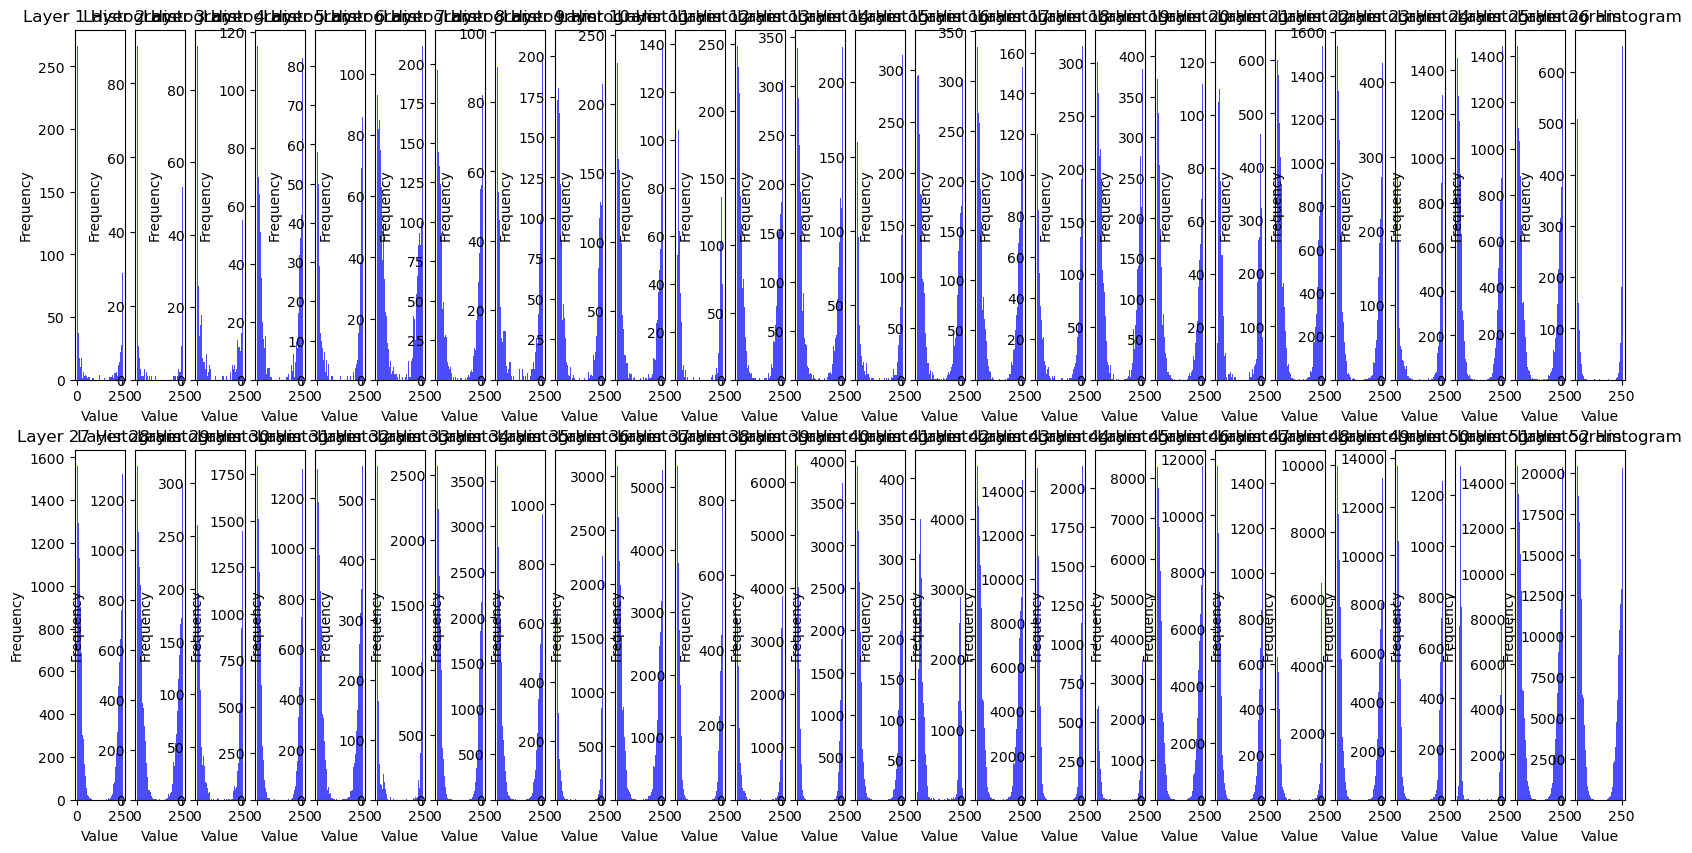

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axes = plt.subplots(2, len(weights_biases)//2, figsize=(20, 10))  # 2 rows and 4 columns

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histograms for each layer
for i in range(len(weights_biases)):
    temp = weights_biases[i].flatten()
    
    # Plot temp as histogram
    axes[i].hist(temp, bins=100, color='blue', alpha=0.7)
    axes[i].set_title(f"Layer {i+1} Histogram")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
